In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

# Required Facts

A system in thermal equilibrium with a temperature bath. Probability $p_\mu$ of being in state $\mu$ with energy $E_\mu$ is

 $$p_\mu = \frac{1}{Z} e^{-\beta E_\mu} $$
 
where $Z = \sum_\mu e^{-\beta E_\mu}$ is the **partition function**. At equilbrium, the following must be true

$$\sum_\nu p_\mu P(\mu \to \nu) = \sum_\nu p_\nu P(\nu \to \mu)$$

where $P(\mu \to \nu)$ is the probability of going from state $\mu$ to $\nu$. For our numerical methods, this is difficult to enforce, but we can make it be true be setting the **detailed balance condition**

$$p_\mu P(\mu \to \nu) =p_\nu P(\nu \to \mu)$$

<p align="center">
  <img src="../images/vid14_p1.PNG" alt="drawing" width="400" align="center"/>
</p>


# Ising Model

<p align="center">
  <img src="../images/vid14_p2.PNG" alt="drawing" width="300" align="center"/>
</p>

The total energy is

$$E_\mu = \sum_{<i,j>}-J\sigma_i \sigma_j $$

where $\sigma_i$ is the spin of a single particle in the lattice (either -1 or 1) and the sum over $<i,j>$ means summing over nearest neighbours for all points in the lattice. $\mu$ corresponds to a particular configuration of the spins. Now, satisfying detailed balance

$$\frac{P(\mu \to \nu)}{P(\nu \to \mu)} = \frac{p_\nu}{p_\mu} = e^{-\beta (E_\nu-E_\mu)}$$

# Metropolis Algorithm

**The Idea**: Want to find the equilibrium state $\mu$ in the magnet at a particular temperature $\beta$ (how many $\sigma_i$s are +1 and how many are -1). We'll start with a random lattice of spins, some pointing up and some pointing down, and make it dance around using the equation above until it fixes itself into equilibrium

1. Call the current state $\mu$. 
2. Pick a random particle on the lattice and flip the spin sign. Call the state $\nu$. We want to find the probability that $P(\mu \to \nu)$ that we'll accept this new state
3. * If $E_\nu > E_\mu$ then set $P(\nu \to \mu) = 1$ and thus by the detailed balance equation $P(\mu \to \nu) = e^{-\beta (E_\nu-E_\mu)}$. 
    * if $E_\mu > E_\nu$ then set $P(\mu \to \nu) = 1$. Still satisfies detailed balance!
4. Change to state $\nu$ (i.e. flip the spin of the particle) with the probabilities outlined above. 
5. Go back to step 1. Repeat the whole thing many many times and eventually you'll force out an equilbrium state. 

Thus the only thing that needs to be evaluated is $-\beta(E_\nu - E_\mu) = -\beta J \sum_{k=1}^4 \sigma_i \sigma_k$ where $i$ is the spin being flipped and $\sigma_k$ are the four nearest neighbours to that spin (two dimensions). On the boundaries, sometimes things might have less than 4 neighbours

In [2]:
# 50 by 50 grid
N = 1000

Generate some initial random grids of spins

In [3]:
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = np.random.random((N,N))
lattice_p = np.zeros((N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

Show initial lattice of spins

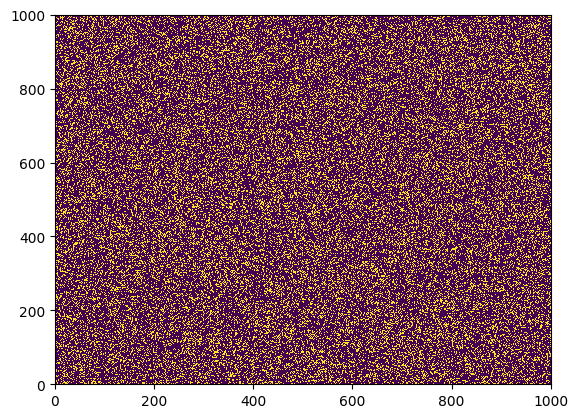

In [4]:
plt.pcolormesh(lattice_n)

Function to get the energy $E/J = -\sum_{<i,j>} \sigma_i\sigma_j$

In [5]:
kern = generate_binary_structure(2, 1) 
kern[1][1] = False

In [6]:
kern

array([[False,  True, False],
       [ True, False,  True],
       [False,  True, False]])

In [7]:
def get_energy_arr(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr

def get_energy(lattice):
    return get_energy_arr(lattice).sum()

def get_dE_arr(lattices):
    return -2*get_energy_arr(lattices)

**The metropolis algorithm**:

* Takes in initial 2d grid of spins, number of time steps to run algoritm for, and temperature $BJ$
* Returns the total spin of all the atoms

In [8]:
def metropolis(spin_arr, n_iters, BJ):
    energies = []
    avg_spins = []
    spin_arr = spin_arr.copy()
    for t in range(n_iters):
        i = np.random.randint(0,2)
        j = np.random.randint(0,2)
        dE = get_dE_arr(spin_arr)[i::2,j::2]
        change = (dE>=0)*(np.random.random(dE.shape) < np.exp(-BJ*dE)) + (dE<0)
        spin_arr[i::2,j::2][change] *=-1
        energies.append(get_energy(spin_arr))
        avg_spins.append(spin_arr.sum()/N**2)
    return np.array(avg_spins), np.array(energies)

Get arrays of spins and energies throughout the dance (this is NOT representative of time evolution: its merely a tool used to reach equilibrium)

In [9]:
spins, energies = metropolis(lattice_p, 1000, 0.5)

In [10]:
spins.shape

(1000,)

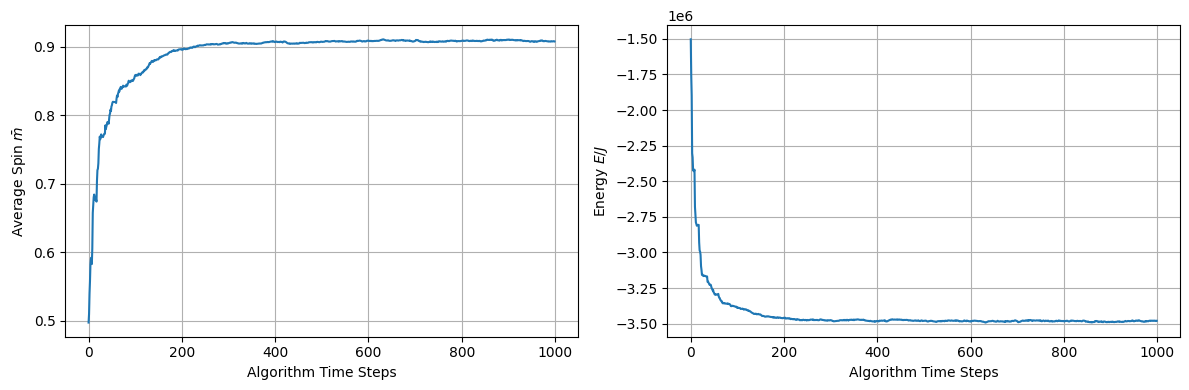

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
plt.show()

We can get $\bar{m}$ and $E/J$ for many different values of $\beta J$. The values will be the average of the last 100000 points on the figure above.

In [ ]:
def get_spin_energy(lattice, BJs):
    spins_avg = []
    energies_avg = []
    energies_std = []
    for BJ in BJs:
        spins, energies = metropolis(lattice, 1000, BJ)
        spins_avg.append(np.mean(spins[-400:]))
        energies_avg.append(np.mean(energies[-400:]))
        energies_std.append(np.std(energies[-400:]))
        spins, energies = metropolis(lattice, 1000, BJ)
    return np.array(spins_avg), np.array(energies_avg), np.array(energies_std)


BJs = 1/np.linspace(1, 3, 20)
spins_avg_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
spins_avg_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

Can look at $\bar{m}$ as a function of temperature $T = 1/\beta k = J/(\beta J)k$

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, spins_avg_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, spins_avg_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

Plot heat capacity as a function of time, using the fact that 

$$C_V = \sigma_E^2 / T^2 $$

$$= (\left<E^2\right>-\left<E\right>^2) \cdot \beta^{2} k^2$$

$$= \left(\left<\left(\frac{E}{J}\right)^2\right>-\left<\frac{E}{J}\right>^2 \right) \cdot (\beta J)^{2} k^2 $$

$$= \sigma_{E/J}^2 \cdot (\beta J)^{2} k^2$$

In [ ]:
plt.plot(1/BJs, E_stds_n*BJs, label='75% of spins started negative')
plt.plot(1/BJs, E_stds_p*BJs, label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()